## Determining if two regexes are equivalent

We will need to define our loss function such that it rewards a prediction
$\hat{y}$ if $y$ and $\hat{y}$ recognize the same strings. How do we tell
whether two regexes recognize the same strings? The classic algorithm
has us do the following:

1. Convert $y$ and $\hat{y}$ to NFAs $N$ and $\hat{N}$.
2. Convert $N$ and $\hat{N}$ to deterministic finite automata (DFAs) $D$ and
   $\hat{D}$.
3. Use the table-filling algorithm to determine if the start states of $D$ and
   $\hat{D}$ are equivalent.

In this section, we develop the code necessary for steps 2 and 3. Step 1 was
already covered when we converted a regex to an NFA for the purpose of
generating strings matching the regex.

### Step 1: Convert regex to NFA

Automata-Theory-Constructions already had code for this, which I modified a little (see `regex_to_nfa()`).

### Step 2: Convert NFA to DFA

To convert a nondeterministic finite automaton to a deterministic finite
automaton that recognizes the same language, we use the classic subset
construction. (A good description of the subset construction can be found in
M. Sipser, _Introduction to the Theory of Computation_).

We first write a function to compute the set of all NFA states reachable from
a given NFA state by following only transitions labeled with $\epsilon$, the
empty string. Recall that $\epsilon$ is represented by `$` in our code.

In [1]:
%run 01_regex.ipynb

e*(bb+eb)((a+b)(c+b))*
de+a+e+(e+b)*+(b+c+d)(b+c+a*)
(e*+a+b)(be+b+d)(e*+e*)*
(bbb(e+a))*
e*
(c*(a+c)(c*+b))*
((cb)*+c*)(ea+a+e)b*d*
e
((e+d)*+eeaa)*
(d+b)e*(b+a)(c+d)a*
['a', '.', 'b', '*']
['(', 'a', '.', 'b', ')', '*']
['(', 'a', '+', 'b', ')', '*', '.', 'c']
['a', 'b', '.']
['a', 'b', '.']
['a', 'b', '*', '.']
['a', 'b', '.', '*']
['a', 'b', '+', '*', 'c', '.']
ab
ab*
(ab)*
(a+b)*c
(<__main__.NFAState object at 0x7f0025cb03d0>, <__main__.NFAState object at 0x7f0025a67880>)
(<__main__.NFAState object at 0x7f0025cb0100>, <__main__.NFAState object at 0x7f0025a67af0>)
(<__main__.NFAState object at 0x7f0025cb05b0>, <__main__.NFAState object at 0x7f0025a67910>)
(<__main__.NFAState object at 0x7f0025cb0100>, <__main__.NFAState object at 0x7f0025a41c30>)
regex ab*
:abbbbb
:abbb
:a
:a
:ab
:ab
:abb
:abbbb
:a
:a
-----
regex (ab)*
:
:
:
:ab
:
:
:
:
:ab
:
-----
regex (a+b)*c*
:
:
:
:
:acc
:acc
:abc
:b
:c
:
-----
regex ba+b+c*+c
:
:ccc
:c
:b
:c
:c
:c
:c
:c
:c
-----


In [2]:
def epsilon_closure(states):
    """
    Compute the set of all states that can be reached from the given states by
    following only epsilon ($) transitions. 

    Args:
      states: iterable of NFAState
      visited: set of already visited states

    Returns:
      frozenset of states reachable from states by following only epsilon ($)
      transitions.
    """
    
    def helper(states, visited):    
        for state in states:
            if state not in visited:
                visited.add(state)
                try:
                    helper(state.next_state['$'], visited)
                except KeyError:
                    pass

    visited = set()
    helper(states, visited)
    
    return frozenset(visited)

To test `epsilon_closure()`, we use a couple of NFAs with $\epsilon$ transitions. The first is structured like this:

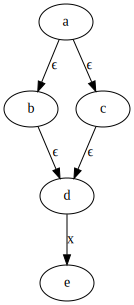

In [3]:
dot = graphviz.Digraph()
dot.node('a')
dot.node('b')
dot.node('c')
dot.node('d')
dot.node('e')
dot.edge('a', 'b', 'ϵ')
dot.edge('a', 'c', 'ϵ')
dot.edge('b', 'd', 'ϵ')
dot.edge('c', 'd', 'ϵ')
dot.edge('d', 'e', 'x')
dot

In [4]:
a = NFAState()
b = NFAState()
c = NFAState()
d = NFAState()
e = NFAState()

a.next_state['$'] = [b, c]
b.next_state['$'] = [d]
c.next_state['$'] = [d]
d.next_state['x'] = [e]

assert epsilon_closure([a]) == {a, b, c, d}

The second graph is structured as follows:

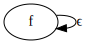

In [5]:
dot = graphviz.Digraph()
dot.edge('f', 'f', 'ϵ')
dot

In [6]:
f = NFAState()
f.next_state['$'] = [f]

assert epsilon_closure([f]) == {f}

Having written a function to compute the $\epsilon$-closure of a collection of
states, we now write a function that converts an NFA to a DFA. This is the
well-known subset construction. We find the reachable sets of states using
depth first search. Given a set of NFA states constituting a DFA state, and a
symbol, the search finds the set of NFA states reachable from the DFA state by
following the symbol.

Unlike many presentations of the subset construction, we don't compute the
power set of NFA states up front, and instead let search find the reachable DFA
states for us. We might avoid creating all $2^{|Q|}$ subsets of the NFA states
$Q$ in some cases (though in the worst case we will visit $\Omega(2^{|Q|})$
states). 

In [7]:
# A state in a deterministic finite automaton.
class DFAState:
    def __init__(self, is_accepting):
        self.is_accepting = is_accepting
        self.next_state = {}

    def __str__(self):
        lines = ['DFAState ' + str(id(self))]
        if self.is_accepting:
            lines.append('accepting')
        for symbol, state in self.next_state.items():
            lines.append(f'\t{symbol}:\t{str(id(state))}')
        return '\n'.join(lines)


# A deterministic finite automaton.
class DFA:
    def __init__(self, states, start, symbols):
        self.states = states
        self.start = start
        self.symbols = symbols

    def __str__(self):
        lines = []
        for state in self.states:
            lines.append('-----')
            lines.append(str(id(state)))
            if state == self.start:
                lines.append('start')
            if state.is_accepting:
                lines.append('accepting')
            for symbol, state in state.next_state.items():
                lines.append(f'\t{symbol}:\t{str(id(state))}')
        return '\n'.join(lines)


def nfa_to_dfa(start, end, symbols):
    """
    Convert an NFA to a DFA.

    Args:
      start: the start NFAState
      end: the end NFAState
      symbols: the alphabet of the NFA

    Returns:
      a DFA
    """

    def is_accepting(nfa_states):
        return any(s == end for s in nfa_states)
    
    dfa_states = {} # key: set of NFAState, value: DFAState
    nfa_states = {} # key: DFAState, value: set of NFAState

    closure = epsilon_closure([start])
    start_state = DFAState(is_accepting(closure))
    dfa_states[closure] = start_state
    nfa_states[start_state] = closure

    frontier = [start_state]
    visited = set()
    
    while len(frontier) > 0:
        state = frontier.pop()

        if state in visited:
            continue

        for symbol in symbols:
            # find NFA states reachable from state by following symbol
            reachable = set()

            for nfa_state in nfa_states[state]:
                try:
                    reachable.update(nfa_state.next_state[symbol])
                except KeyError:
                    pass

            reachable = epsilon_closure(reachable)
            
            if reachable in dfa_states:
                next = dfa_states[reachable]
            else:
                next = DFAState(is_accepting(reachable))
                dfa_states[reachable] = next
                nfa_states[next] = reachable
            
            state.next_state[symbol] = next
            
            if next not in visited:
                frontier.append(next)
        
        visited.add(state)
    
    return DFA(visited, start_state, symbols) 

In [8]:
regexes = ['a', 'b*']
symbols = ['a', 'b']

for i in range(len(regexes)):
    start, end = regex_to_nfa(regexes[i])
    dfa = nfa_to_dfa(start, end, symbols[i])
    print(f'DFA for {regexes[i]}:')
    print(str(dfa))

DFA for a:
-----
139638609177248
	a:	139638609177248
-----
139638609182240
start
	a:	139638609177392
-----
139638609177392
accepting
	a:	139638609177248
DFA for b*:
-----
139638609178640
accepting
	b:	139638609178640
-----
139638609182432
start
accepting
	b:	139638609178640


### Step 3: Determine if two DFAs recognize the same strings

We first introduce a disjoint sets data structure based on the union-find algorithm.

In [9]:
# A disjoint sets data structure.
class UnionFind:
    def __init__(self, items):
        self.parent = {i: i for i in items}
        self.size = {i: 1 for i in items}

    def find(self, item):
        """
        Find the representative of an item.

        Args:
          item: the item for which the representative is wanted

        Returns:
          the representative of item
        """
        if self.parent[item] == item:
            return item
        else:
            parent = self.find(self.parent[item])
            self.parent[item] = parent
            return parent

    def union(self, item0, item1):
        """
        Merge two items.

        Args:
          item0 an item
          item1 another item (but could also be the same as item0)
        """
        find0 = self.find(item0)
        find1 = self.find(item1)
        if find0 == find1:
            return
        if self.size[find0] < self.size[find1]:
            find0, find1 = find1, find0
        self.parent[find1] = find0
        self.size[find0] += self.size[find1]

In [10]:
uf = UnionFind(range(6))

for i in range(6):
    for j in range(i):
        assert uf.find(i) != uf.find(j)

uf.union(0, 3)
uf.union(1, 4)
uf.union(2, 5)

for i in range(6):
    for j in range(6):
        assert (uf.find(i) == uf.find(j)) == (i % 3 == j % 3)

Next we write a function that determines if two DFA states $q_0$ and $q_1$ are
equivalent, in the sense that for all strings $s$, the state resulting from
following $s$ starting at $q_0$ is final if and only if the state resulting
from following $s$ starting at $q_1$ is final.

The algorithm for this is known as the "table-filling" algorithm. A good
description can be found in
[these lecture notes](https://people.csail.mit.edu/rrw/6.045-2020/lec5-color.pdf)
by Ryan Williams.

In [11]:
def equivalent_states(dfa):
    """
    Compute the equivalent states of a DFA.

    Args:
      dfa: a DFA

    Returns:
      a UnionFind such that find(state0) == find(state1) iff state0 and state1
      are equivalent
    """

    different = set()

    for s0 in dfa.states:
        for s1 in dfa.states:
            if s0 == s1:
                continue
            if s0.is_accepting ^ s1.is_accepting:
                different.add((s0, s1))
                different.add((s1, s0))

    stop = False

    while not stop:
        stop = True
        
        for s0 in dfa.states:
            for s1 in dfa.states:
                if s0 == s1 or (s0, s1) in different:
                    continue

                for symbol in dfa.symbols:
                    next0 = s0.next_state[symbol]
                    next1 = s1.next_state[symbol]
                    if (next0, next1) in different:
                        different.add((s0, s1))
                        different.add((s1, s0))
                        stop = False

    result = UnionFind(dfa.states)
    for s0 in dfa.states:
        for s1 in dfa.states:
            if (s0, s1) not in different:
                result.union(s0, s1)

    return result

We can use use our function that computes the equivalent states of a DFA to
also determine whether two DFAs are equivalent. The idea is to form a "union"
DFA $D = (Q_0 \cup Q_1, \Sigma, \delta_0 \cup \delta_1, -, F_0 \cup F_1)$,
then test whether $q_0$ and $q_1$ are equivalent in $D$. The start state
doesn't matter, hence the "$-$". The idea comes from
[these lecture notes by Ana Bove](https://www.cse.chalmers.se/edu/year/2012/course/TMV026/lec10.pdf).

In [12]:
def are_equivalent_dfas(dfa0, dfa1):
    """
    Determine whether two DFAs have the same language.

    Args:
      dfa0: a DFA
      dfa1: another DFA, which must have states disjoint from dfa0

    Returns:
      True iff dfa0 and dfa1 have the same language
    """

    if sorted(dfa0.symbols) != sorted(dfa1.symbols):
        return False
    
    states = set(dfa0.states)
    states.update(dfa1.states)

    # initial state does not matter (it could be anything)
    union = DFA(states, dfa0.start, dfa0.symbols)

    equiv = equivalent_states(union)

    return equiv.find(dfa0.start) == equiv.find(dfa1.start)

### Wrapping up steps 1-3

We finish up with a function to test the equivalence of two regular
expressions. First we write a function that extracts the symbols from a regular
expression.

In [13]:
def regex_to_symbols(regex):
    """
    Given a regular expression, return its symbols.

    Args:
      regex: a regular expression

    Returns:
      a string containing the symbols of regex
    """

    # split regex into single characters
    chars = set([*regex])

    # remove operators and convert to list
    nonoperators = list(chars - set(operators))

    # sort them
    nonoperators.sort()

    # join them into a string
    return "".join(nonoperators)

In [14]:
regexes0 = ['a*', '(a+b)*', 'a']
regexes1 = ['a**', '(a*+b*)*', 'b']
symbols = ['a', 'ab', 'ab']
answer = [True, True, False]

for i in range(len(regexes0)):
    start0, end0 = regex_to_nfa(regexes0[i])
    start1, end1 = regex_to_nfa(regexes1[i])
    dfa0 = nfa_to_dfa(start0, end0, regex_to_symbols(regexes0[i]))
    dfa1 = nfa_to_dfa(start1, end1, regex_to_symbols(regexes1[i]))
    assert are_equivalent_dfas(dfa0, dfa1) == answer[i]

Now, finally, we write a function that tests the equivalence of two regular
expressions.

In [15]:
def are_equivalent_regexes(regex0, regex1):
    """
    Determine whether two regular expressions recognize the same strings.

    Args:
      regex0: a regex
      regex1: also a regex

    Returns:
      True iff regex0 and regex1 recognize the same strings.
    """

    start0, end0 = regex_to_nfa(regex0)
    start1, end1 = regex_to_nfa(regex1)

    symbols0 = regex_to_symbols(regex0)
    symbols1 = regex_to_symbols(regex0)
    
    dfa0 = nfa_to_dfa(start0, end0, symbols0)
    dfa1 = nfa_to_dfa(start1, end1, symbols1)

    return are_equivalent_dfas(dfa0, dfa1)

### Appendix: Minimizing DFAs

In this section I develop some code to minimize a DFA. I didn't need it for
determining the equivalence of regular expressions, but I initially thought I
would, and it seemed a shame to delete it.

DFA minimization typically requires pruning unreachable states. By
construction, the states in the DFAs constructed from NFAs in this notebook are
all reachable, so I didn't have to prune them.

In [16]:
def minimize(dfa):
    equiv = equivalent_states(dfa)

    states = {} # map from states of input DFA to states of minimized DFA
    
    for s in dfa.states:
        find = equiv.find(s)

        if find not in states:
            states[find] = DFAState(find.is_accepting)

        states[s] = states[find]

    done = set() # states of minimized DFA for which we have next states

    for old in dfa.states:
        new = states[old]
        if new not in done:
            new.next_state = {s: states[old.next_state[s]] for s in dfa.symbols}
            done.add(new)
    
    return DFA(done, states[dfa.start], dfa.symbols)

In [17]:
regexes = ['b*', '(a+b)*', '(a*+b*)*']
symbols = ['b', 'ab', 'ab']

for i in range(len(regexes)):
    start, end = regex_to_nfa(regexes[i])
    dfa = nfa_to_dfa(start, end, symbols[i])
    
    print(f'DFA for {regexes[i]}:')
    print(str(dfa))

    min = minimize(dfa)
    print(f'Minimized DFA for {regexes[i]}:')
    print(str(min))

DFA for b*:
-----
139638609169952
start
accepting
	b:	139638608244176
-----
139638608244176
accepting
	b:	139638608244176
Minimized DFA for b*:
-----
139638608233712
start
accepting
	b:	139638608233712
DFA for (a+b)*:
-----
139638608240384
accepting
	a:	139638608240384
	b:	139638608247056
-----
139638608247056
accepting
	a:	139638608240384
	b:	139638608247056
-----
139638609178976
start
accepting
	a:	139638608240384
	b:	139638608247056
Minimized DFA for (a+b)*:
-----
139638608246768
start
accepting
	a:	139638608246768
	b:	139638608246768
DFA for (a*+b*)*:
-----
139638608237696
accepting
	a:	139638608236736
	b:	139638608237696
-----
139638609169952
start
accepting
	a:	139638608236736
	b:	139638608237696
-----
139638608236736
accepting
	a:	139638608236736
	b:	139638608237696
Minimized DFA for (a*+b*)*:
-----
139638608246912
start
accepting
	a:	139638608246912
	b:	139638608246912
